In [34]:
from hydra import compose, initialize
from pathlib import Path
import pandas as pd
import numpy as np
from rdkit import Chem
from IPython.display import SVG
import matplotlib.pyplot as plt
from ergochemics.draw import draw_molecule
from collections import defaultdict
from scipy.stats import hmean, gmean # Keep
from ergochemics.mapping import rc_to_nest

with initialize(version_base=None, config_path="../configs/filepaths"):
    filepaths = compose(config_name="filepaths")

In [35]:
# Load

rule_id = 435
embed_mat = np.load(Path(filepaths.interim_data) / str(rule_id) / 'bfm.npy')
examples = pd.read_parquet(Path(filepaths.interim_data) / str(rule_id) / 'subgraph_instances.parquet')

In [36]:
# Transform

p1 = embed_mat.sum(axis=0) / embed_mat.shape[0]
sgids = np.argsort(p1)[::-1]
examples['reaction_center'] = examples['reaction_center'].apply(rc_to_nest)
examples.head()

,subgraph_id,rxn_id,smarts,am_smarts,reaction_center,sg_idxs,sep_sg_idxs
0,0,10000,CC(=O)C1CCC2C3C(O)C=C4CC(O)CCC4(C)C3CCC12C.NC(...,[CH3:71][C:68](=[O:72])[CH:64]1[CH2:61][CH2:56...,"(((8, 9), (3, 4, 5, 6, 7, 47)), ((0, 1, 2, 3, ...",[64],;40>>
1,1,10000,CC(=O)C1CCC2C3C(O)C=C4CC(O)CCC4(C)C3CCC12C.NC(...,[CH3:71][C:68](=[O:72])[CH:64]1[CH2:61][CH2:56...,"(((8, 9), (3, 4, 5, 6, 7, 47)), ((0, 1, 2, 3, ...",[15],15;>>
2,2,10000,CC(=O)C1CCC2C3C(O)C=C4CC(O)CCC4(C)C3CCC12C.NC(...,[CH3:71][C:68](=[O:72])[CH:64]1[CH2:61][CH2:56...,"(((8, 9), (3, 4, 5, 6, 7, 47)), ((0, 1, 2, 3, ...",[28],;4>>
3,3,10000,CC(=O)C1CCC2C3C(O)C=C4CC(O)CCC4(C)C3CCC12C.NC(...,[CH3:71][C:68](=[O:72])[CH:64]1[CH2:61][CH2:56...,"(((8, 9), (3, 4, 5, 6, 7, 47)), ((0, 1, 2, 3, ...",[34],;10>>
4,4,10000,CC(=O)C1CCC2C3C(O)C=C4CC(O)CCC4(C)C3CCC12C.NC(...,[CH3:71][C:68](=[O:72])[CH:64]1[CH2:61][CH2:56...,"(((8, 9), (3, 4, 5, 6, 7, 47)), ((0, 1, 2, 3, ...",[42],;18>>


Top subgraphs over all reactions in subset

Subgraph id: 15
Probability: 1.00
Example shown: 10000


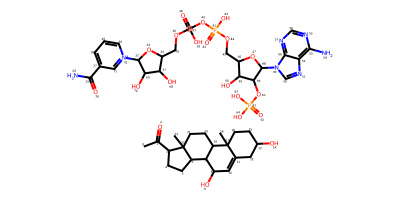

Subgraph id: 14
Probability: 1.00
Example shown: 10000


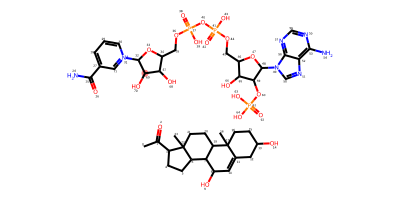

Subgraph id: 17
Probability: 1.00
Example shown: 10000


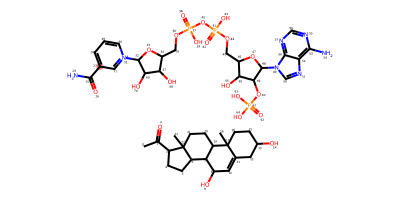

Subgraph id: 4943
Probability: 1.00
Example shown: 10000


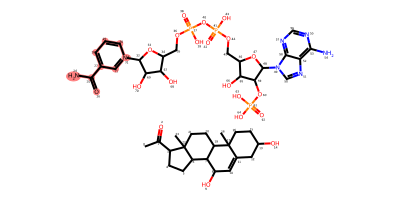

Subgraph id: 4942
Probability: 1.00
Example shown: 10000


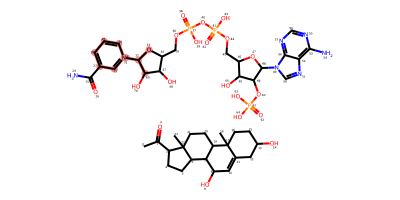

Subgraph id: 4941
Probability: 1.00
Example shown: 10000


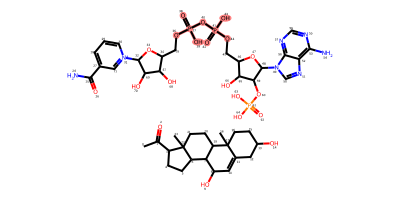

Subgraph id: 48
Probability: 1.00
Example shown: 10000


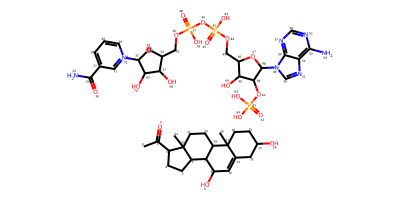

Subgraph id: 45
Probability: 1.00
Example shown: 10000


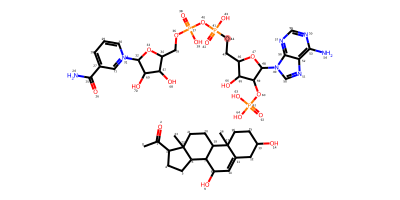

Subgraph id: 44
Probability: 1.00
Example shown: 10000


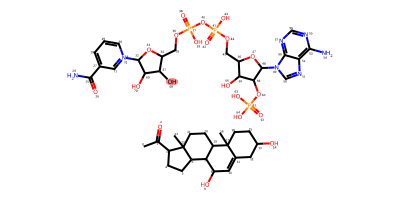

Subgraph id: 42
Probability: 1.00
Example shown: 10000


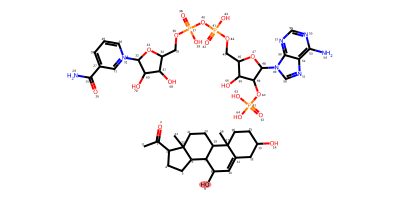

Subgraph id: 41
Probability: 1.00
Example shown: 10000


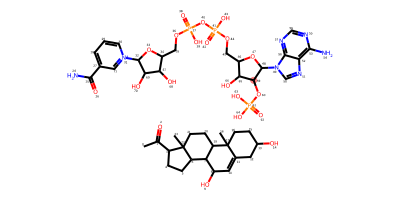

In [37]:
topk = 10

ct = 0
for sgid in sgids:
    if ct > topk:
        break

    # if p1[sgid] == 1:
    #     continue

    ex = examples.loc[examples['subgraph_id'] == sgid].iloc[0]
    sma = ex['smarts']
    rcts = sma.split('>>')[0]
    rcts = Chem.MolFromSmiles(rcts)
    sg_idxs = ex['sg_idxs'].tolist()
    print(f"Subgraph id: {sgid}")
    print(f"Probability: {p1[sgid]:.2f}")
    print(f"Example shown: {ex['rxn_id']}")
    img = draw_molecule(rcts, size=(400, 200), highlight_atoms=sg_idxs, draw_options={"addAtomIndices": True})
    display(SVG(img))

    # with open(Path(filepaths.artifacts) / "imgs" / "top_sgs_v0" / f"p_{p1[sgid]*100:.0f}_sg_{sgid}_ex_{ex['rxn_id']}.svg", 'w') as f:
    #     f.write(img)

    ct += 1
    

Top subgraphs for given reaction

In [38]:
rxn_id = 734
len(examples.loc[examples['rxn_id'] == str(rxn_id)])
examples.loc[examples['rxn_id'] == str(rxn_id)].head()

,subgraph_id,rxn_id,smarts,am_smarts,reaction_center,sg_idxs,sep_sg_idxs


In [39]:
topk = 10
ct = 0
atom_probs = defaultdict(list)
rxn_of_interest = examples.loc[examples['rxn_id'] == str(rxn_id)].sort_values(by='subgraph_id', key=lambda x: p1[x], ascending=False)
for i, subgraph in rxn_of_interest.iterrows():
    sma = subgraph['smarts']
    sgid = subgraph["subgraph_id"]
    sg_idxs = subgraph['sg_idxs'].tolist()
    
    for idx in sg_idxs:
        atom_probs[idx].append(p1[sgid])

    if ct < topk:
        rcts = sma.split('>>')[0]
        rcts = Chem.MolFromSmiles(rcts)
        print(f"Subgraph id: {sgid}")
        print(f"Probability: {p1[sgid]:.2f}")
        img = draw_molecule(rcts, size=(400, 200), highlight_atoms=sg_idxs, draw_options={"addAtomIndices": True})
        display(SVG(img))

        # with open(Path(filepaths.artifacts) / "imgs" / "ex_decarb_top_sgs" / f"rxn_{rxn_id}_p_{p1[sgid]*100:.0f}_sg_{sgid}.svg", 'w') as f:
        #     f.write(img)
    
    
    ct += 1

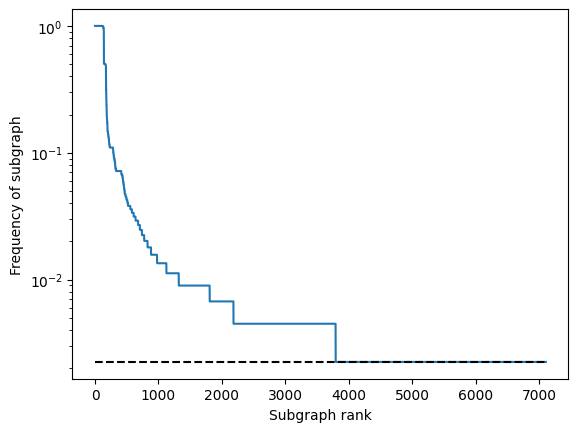

In [40]:
fig, ax = plt.subplots()
ax.plot(np.sort(p1)[::-1])
ax.hlines(1 / embed_mat.shape[0], 0, embed_mat.shape[1], colors='black', linestyles='--')
ax.set_yscale('log')
ax.set_xlabel('Subgraph rank')
ax.set_ylabel('Frequency of subgraph')
plt.show()

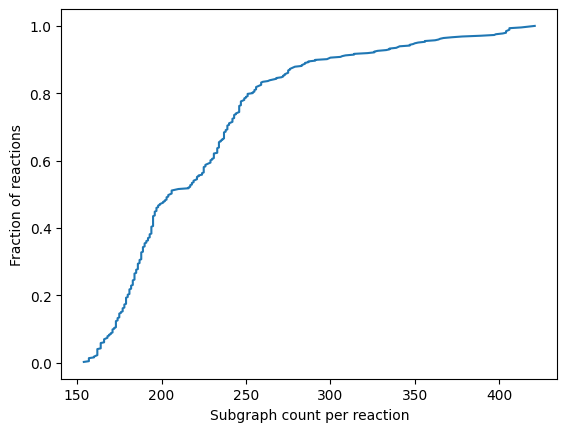

In [41]:
sg_cts = embed_mat.sum(axis=1)
srt_sg_cts = np.sort(sg_cts)
ycdf = np.arange(1, len(srt_sg_cts) + 1) / len(srt_sg_cts)
fig, ax = plt.subplots()
ax.plot(srt_sg_cts, ycdf)
ax.set_xlabel('Subgraph count per reaction')
ax.set_ylabel('Fraction of reactions')
plt.show()


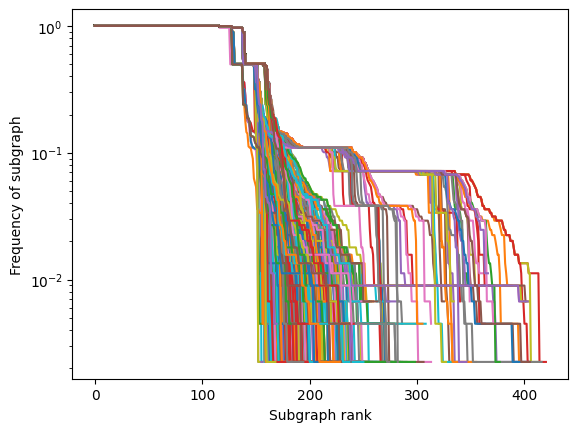

In [42]:
sgids_by_rxn = [np.nonzero(embed_mat[i])[0] for i in range(embed_mat.shape[0])]

fig, ax = plt.subplots()
for row in sgids_by_rxn:
    row_probs = np.sort(p1[row])[::-1]
    ax.plot(row_probs)

ax.set_yscale('log')
ax.set_xlabel('Subgraph rank')
ax.set_ylabel('Frequency of subgraph')
plt.show()

Select atoms apart of union of subgraphs > threshold on frequency

Example shown: 10000


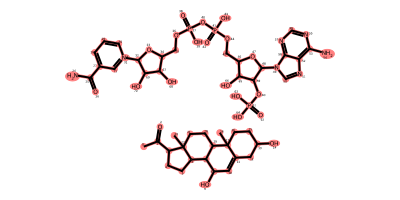

Example shown: 10032


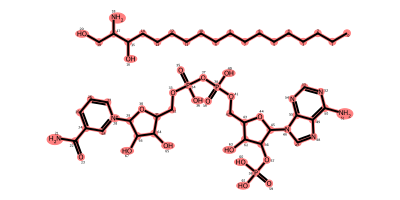

Example shown: 10038


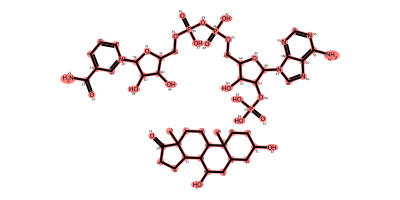

Example shown: 10050


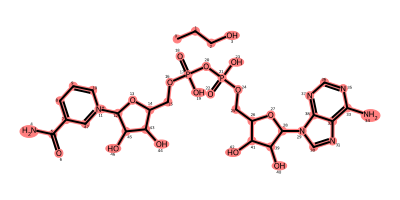

Example shown: 10076


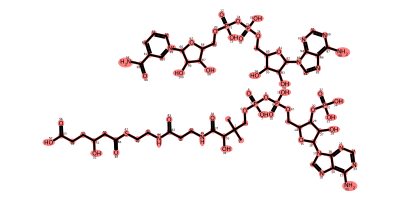

Example shown: 10079


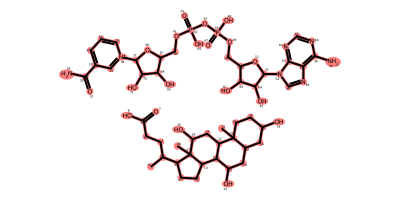

Example shown: 10138


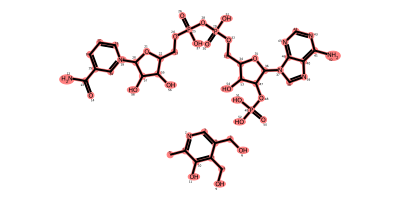

Example shown: 10242


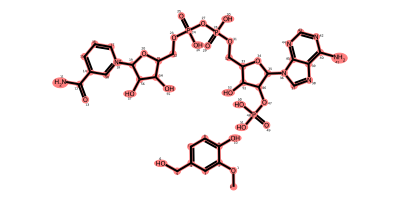

Example shown: 10252


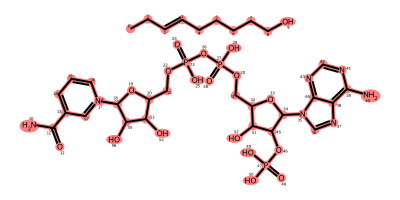

Example shown: 10293


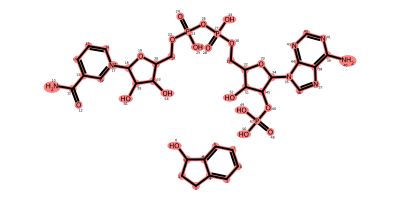

Example shown: 10338


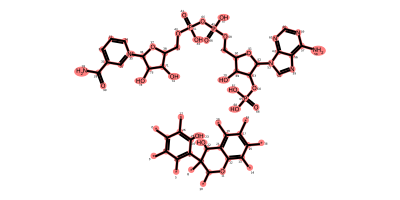

In [43]:
scl = 1
lb = scl / embed_mat.shape[0]
stop = 10

for i, (name, gb) in enumerate(examples.groupby(by="rxn_id")):
    smarts = gb.iloc[0]['smarts']
    rcts = smarts.split('>>')[0]
    rcts = Chem.MolFromSmiles(rcts)
    
    sg_idxs = set()
    for _, row in gb.iterrows():
        if p1[row['subgraph_id']] >= lb:
            sg_idxs.update(row['sg_idxs'].tolist())

    print(f"Example shown: {name}")
    display(SVG(draw_molecule(rcts, size=(400, 200), highlight_atoms=sg_idxs, draw_options={"addAtomIndices": True})))

    i += 1

    if i > stop:
        break

Select by probability of each atom

In [44]:
# aggs = {
#     "arithmetic": np.mean,
#     "harmonic": hmean,
#     "geometric": gmean,
#     "max": np.max
# }

# fig, ax = plt.subplots(ncols=1, nrows=len(aggs), figsize=(7, 9))   
# for i, (agg, func) in enumerate(aggs.items()):
#     for idx, probs in atom_probs.items():
#         ax[i].bar(idx, func(probs))
#     ax[i].set_title(agg)
#     ax[i].set_xticks(np.arange(len(atom_probs)))
#     ax[i].grid()
# plt.tight_layout()
# plt.show()

In [45]:
# all_atom_probs = defaultdict(list)
# for _, row in examples.iterrows():
#     rxn_id = row['rxn_id']
#     sgid = row['subgraph_id']
#     for aidx in row['sg_idxs']:
#         all_atom_probs[f"{rxn_id}_{aidx}"].append(p1[sgid])

# mean_probs = []
# for i, (agg, func) in enumerate(aggs.items()):
#     for idx, probs in all_atom_probs.items():
#         mean_probs.append(func(probs))
#     fig, ax = plt.subplots()
#     ycdf = np.arange(1, len(mean_probs) + 1) / len(mean_probs)
#     ax.plot(np.sort(mean_probs), ycdf)
#     ax.grid()
#     ax.set_title(agg)
#     plt.show()

Visualize single sgid over multiple 

Subgraph id: 730
Probability: 0.04


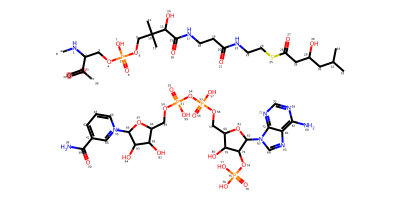

Subgraph id: 730
Probability: 0.04


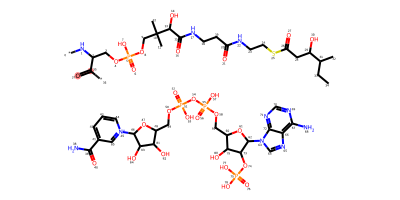

Subgraph id: 730
Probability: 0.04


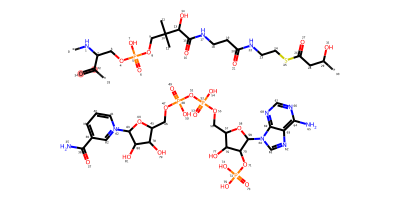

Subgraph id: 730
Probability: 0.04


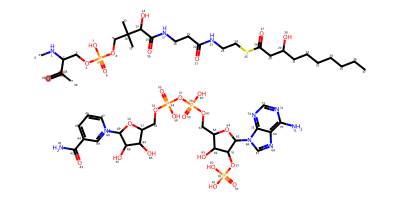

Subgraph id: 730
Probability: 0.04


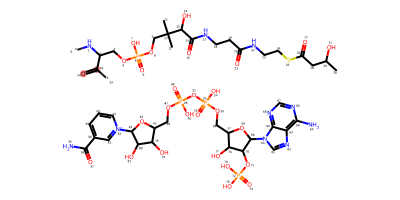

In [46]:
sgid = 730
ct = 0
for i, ex in examples.loc[examples['subgraph_id'] == sgid].iterrows():
    if ct > 4:
        break

    sma = ex['smarts']
    rcts = sma.split('>>')[0]
    rcts = Chem.MolFromSmiles(rcts)
    sg_idxs = ex['sg_idxs'].tolist()
    print(f"Subgraph id: {sgid}")
    print(f"Probability: {p1[sgid]:.2f}")
    display(SVG(draw_molecule(rcts, size=(400, 200), highlight_atoms=sg_idxs, draw_options={"addAtomIndices": True})))
    
    ct +=1

In [47]:
# agg = aggs['max']
# lb = 0.15

# for name, gb in examples.groupby(by="rxn_id"):
#     smarts = gb.iloc[0]['smarts']
#     rcts = smarts.split('>>')[0]
#     rcts = Chem.MolFromSmiles(rcts)
#     aidxs = [atom.GetIdx() for atom in rcts.GetAtoms()]
#     sg_idxs = [elt for elt in aidxs if agg(all_atom_probs[f"{name}_{elt}"]) > lb]
#     print(sorted(sg_idxs, key=lambda x: agg(all_atom_probs[f"{name}_{x}"]), reverse=True))
#     print(f"Example shown: {name}")
#     display(SVG(draw_molecule(rcts, size=(400, 200), highlight_atoms=sg_idxs, draw_options={"addAtomIndices": True})))